<a href="https://colab.research.google.com/github/AnnaVashuk/mts/blob/main/%D0%B4%D0%B7_%D1%88%D0%B0%D0%B4_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mean Squared Error (MSE): 496.96797423528
Mean Absolute Error (MAE): 18.362655594586027


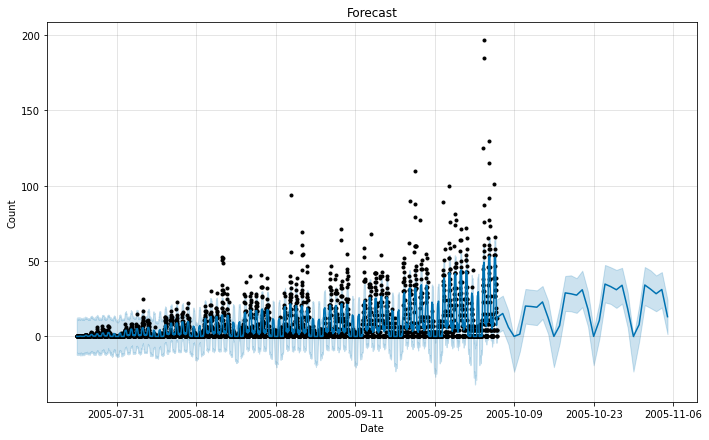

F1-score: 0.4951076227578947


In [ ]:
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score
import matplotlib.pyplot as plt

class EventPredictor:
    def __init__(self):
        self.model = None

    def preprocess_data(self, counters_df, events_df):
        merged_df = pd.merge(counters_df, events_df, how='left', left_on='dt', right_on='dt_start')
        merged_df['event_present'] = 0
        merged_df.loc[(merged_df['dt'] >= merged_df['dt_start']) &
                      (merged_df['dt'] <= merged_df['dt_end']), 'event_present'] = 1
        merged_df['dt'] = pd.to_datetime(merged_df['dt'])

        return merged_df[['dt', 'cnt', 'event_present']]

    def train_model(self, train_df):
        df = train_df[['dt', 'cnt', 'event_present']].copy()
        df = df.rename(columns={'dt': 'ds', 'cnt': 'y'})

        self.model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True)
        self.model.fit(df)

    def predict(self, test_df):
        future = self.model.make_future_dataframe(periods=30)
        future['event_present'] = test_df['event_present']
        forecast = self.model.predict(future)
        forecast['yhat'] = forecast['yhat'].clip(lower=0)

        return forecast

    def evaluate_forecast(self, true_df, forecast_df):
        forecast_filtered = forecast[(forecast['ds'] >= '2005-10-06') & (forecast['ds'] <= '2005-11-05')]
        yhat_values = forecast_filtered['yhat']
        true_values = true_df['cnt'].head(30)
        mse = mean_squared_error(true_values, yhat_values)
        mae = mean_absolute_error(true_values, yhat_values)
        return mse, mae

    def evaluate_events(self, true_events, predicted_events):
        f1 = f1_score(true_events, predicted_events, average='weighted')
        return f1

    def plot_forecast(self, forecast_df):
        self.model.plot(forecast_df)
        plt.xlabel('Date')
        plt.ylabel('Count')
        plt.title('Forecast')
        plt.show()

predictor = EventPredictor()
counters_train_df = pd.read_csv('counters_train.csv')
events_train_df = pd.read_csv('events_train.csv')
counters_test_df = pd.read_csv('counters_test.csv')
events_test_df = pd.read_csv('events_test.csv')

merged_train_df = predictor.preprocess_data(counters_train_df, events_train_df)
merged_test_df = predictor.preprocess_data(counters_test_df, events_test_df)

predictor.train_model(merged_train_df)
forecast = predictor.predict(merged_test_df)

#оценка качества прогноза количества посетителей
mse, mae = predictor.evaluate_forecast(merged_test_df, forecast)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

#визуализация прогноза количества посетителей
predictor.plot_forecast(forecast)

#F1-score задачи бинарной классификации - определения было в день мероприятие или нет
true_events = merged_test_df['event_present']
predicted_events = (forecast['yhat'] > 0.5).astype(int)
predicted_events = predicted_events.head(1488)
f1 = predictor.evaluate_events(true_events, predicted_events)
print("F1-score:", f1)